In [44]:
# Import necessary libraries
import swifter
import numpy as np
import pandas as pd

import statsmodels.api as sm
from scipy.stats import norm, ttest_ind

import textstat
from textblob import TextBlob

import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading

In [ ]:
# Load TSV file
file_path = '../data/00_raw_data/amazon_reviews_us_Books_v1_02.tsv'
df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip', low_memory=False)

In [ ]:
df.info()

In [ ]:
# Convert review_date to datetime
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')

# Filter for 2003–2005
df = df[(df['review_date'].dt.year >= 2003) & (df['review_date'].dt.year <= 2005)]

print(f"Shape of dataset: {df.shape}")

In [ ]:
# Check the first few rows
df.head()

In [ ]:
# Save the filtered DataFrame to a new TSV file
filtered_data_file_path = '../data/01_filtered_data/filtered_data.tsv'
df.to_csv(filtered_data_file_path, sep='\t', index=False)

In [8]:
# Load the filtered DataFrame to a new TSV file
# filtered_data_file_path = '../data/01_filtered_data/filtered_data.tsv'
filtered_data_file_path = '/content/filtered_data.tsv'
df = pd.read_csv(filtered_data_file_path, sep='\t', low_memory=False)

# Convert review_date to datetime
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')

## Data Inspection

In [9]:
# Overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1286157 entries, 0 to 1286156
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   marketplace        1286157 non-null  object        
 1   customer_id        1286157 non-null  int64         
 2   review_id          1286157 non-null  object        
 3   product_id         1286157 non-null  object        
 4   product_parent     1286157 non-null  int64         
 5   product_title      1286157 non-null  object        
 6   product_category   1286157 non-null  object        
 7   star_rating        1286157 non-null  float64       
 8   helpful_votes      1286157 non-null  float64       
 9   total_votes        1286157 non-null  float64       
 10  vine               1286157 non-null  object        
 11  verified_purchase  1286157 non-null  object        
 12  review_headline    1286122 non-null  object        
 13  review_body        1286157 

In [10]:
# Missing values
missing = df.isnull().sum().sort_values(ascending=False)

print("Missing Values:\n", missing[missing > 0])

Missing Values:
 review_headline    35
dtype: int64


In [11]:
# Drop the Null Rows
df = df.dropna()

In [12]:
# Basic statistics
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
marketplace,1286122,1,US,1286122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_id,1286122.0,NaN,NaN,NaN,38868079.224926,12065385.0,29569024.0,40908234.0,50833636.0,53096582.0,12654615.485353
review_id,1286122,1286122,R1MWJLS5EBWG5G,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_id,1286122,415871,043935806X,4624,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_parent,1286122.0,NaN,NaN,NaN,503799192.621607,689.0,257185819.0,505671530.0,752590554.75,999997462.0,287477296.075128
product_title,1286122,389926,Harry Potter and the Order of the Phoenix (Boo...,4861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_category,1286122,1,Books,1286122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
star_rating,1286122.0,NaN,NaN,NaN,4.132781,1.0,4.0,5.0,5.0,5.0,1.286454
helpful_votes,1286122.0,NaN,NaN,NaN,9.724895,0.0,1.0,4.0,10.0,6539.0,26.982455
total_votes,1286122.0,NaN,NaN,NaN,13.427152,0.0,2.0,6.0,14.0,6634.0,32.315443


## Exploratory Data Analysis

In [13]:
df['review_text_full'] = df['review_headline'].fillna('') + ' - ' + df['review_body'].fillna('')

#### Review Lengths

In [14]:
df['review_length'] = df['review_body'].astype(str).apply(len)
df['review_word_count'] = df['review_body'].astype(str).apply(lambda x: len(x.split()))

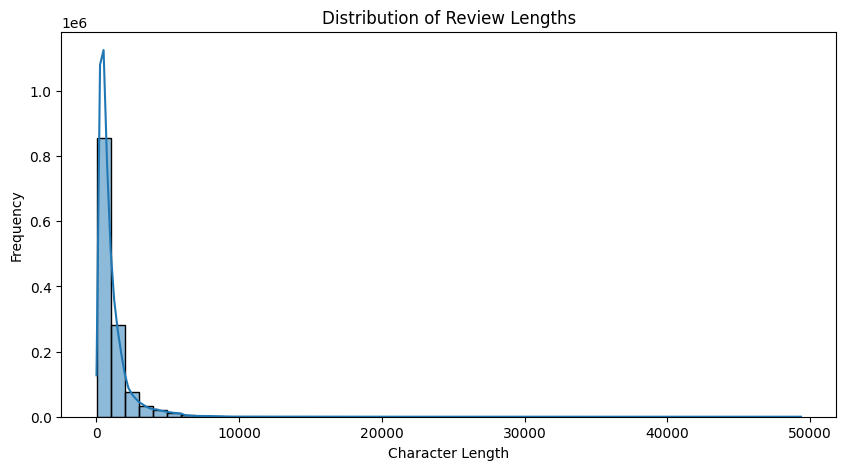

In [15]:
# Distribution of review lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.show()

#### Helpfulness Ratio

In [16]:
# Calculate helpful ratio
def wilson_lower_bound(helpful, total, confidence=0.95):
    if total == 0:
        return 0  # No data → rank low
    z = norm.ppf(1 - (1 - confidence) / 2)
    phat = helpful / total
    return (phat + z**2 / (2 * total) - z * np.sqrt(
        (phat * (1 - phat) + z**2 / (4 * total)) / total)
    ) / (1 + z**2 / total)

In [17]:
# Create a flag for engaged reviews
df['engaged'] = df['total_votes'] > 0

In [18]:
# Calculate helpful ratio
"""Confidence Interval controls how cautious the Wilson score is when estimating
   how helpful a review truly is, based on observed helpful votes.
"""
df['helpful_ratio'] = df.apply(
    lambda row: wilson_lower_bound(row['helpful_votes'], row['total_votes']),
    axis=1
)

####  Class Distribution

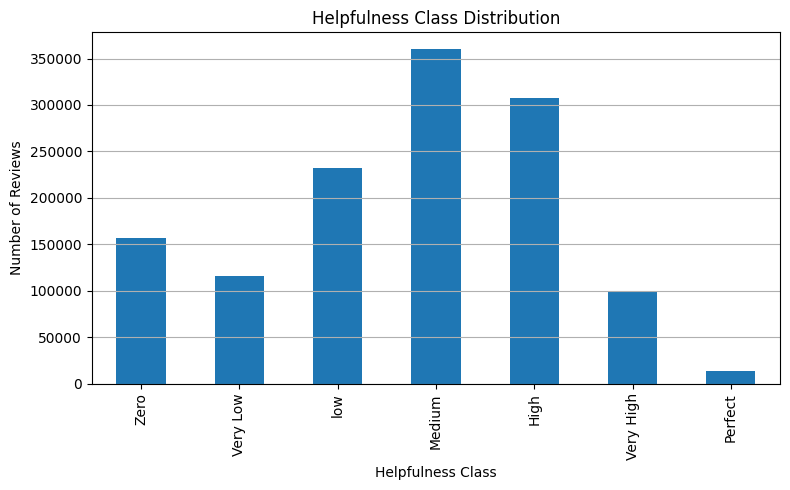

In [19]:
# Define bins and labels for classifying helpfulness scores
bins = [-0.01, 0.0, 0.10, 0.25, 0.5, 0.75, 0.90, 1.0]
labels = ['Zero', 'Very Low', 'low', 'Medium', 'High', 'Very High', 'Perfect']

# Categorize the Wilson score into classes
df['helpful_class'] = pd.cut(df['helpful_ratio'], bins=bins, labels=labels, include_lowest=True)

# Count the distribution
class_distribution = df['helpful_class'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar')
plt.title('Helpfulness Class Distribution')
plt.xlabel('Helpfulness Class')
plt.ylabel('Number of Reviews')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Review Length vs. Helpfulness

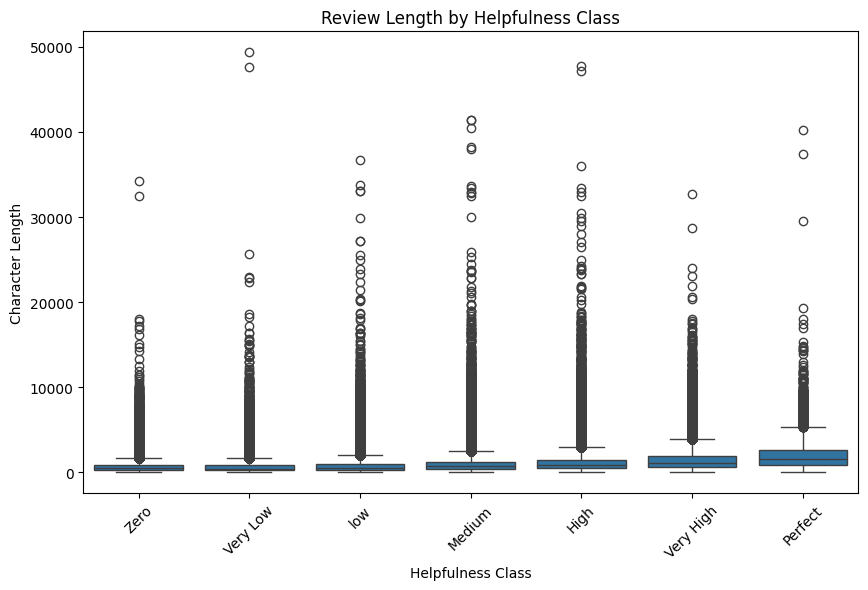

In [20]:
# Boxplot: Review length vs. helpful class
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['helpful_class'].notnull()], x='helpful_class', y='review_length', order=['Zero', 'Very Low', 'low', 'Medium', 'High', 'Very High', 'Perfect'])
plt.title('Review Length by Helpfulness Class')
plt.xlabel('Helpfulness Class')
plt.ylabel('Character Length')
plt.xticks(rotation=45)
plt.show()

#### Star Ratings vs Helpfulness

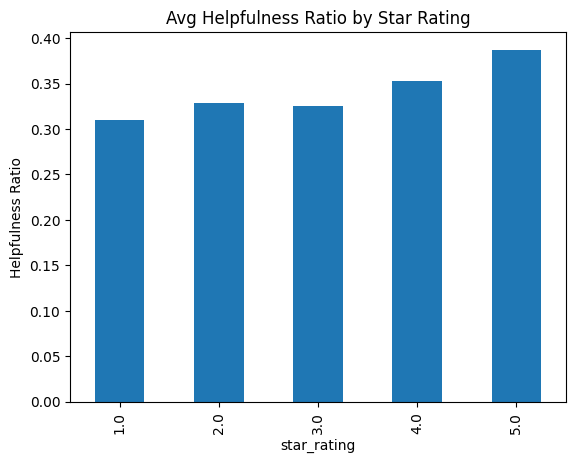

In [21]:
df.groupby('star_rating')['helpful_ratio'].mean().plot(kind='bar')
plt.title('Avg Helpfulness Ratio by Star Rating')
plt.ylabel('Helpfulness Ratio')
plt.show()

#### Top books by review count and their helpfulness.

In [22]:
# Top 10 products by review count
top_products = df['product_parent'].value_counts().head(10).index

# Map a representative product title for each product_parent
title_map = df[df['product_parent'].isin(top_products)].groupby('product_parent')['product_title'] \
             .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])

# Filter and assign titles for plotting
plot_df = df[df['product_parent'].isin(top_products)].copy()
plot_df['product_title_mapped'] = plot_df['product_parent'].map(title_map)
plot_df['review_length'] = plot_df['review_body'].astype(str).str.len()  # precompute safely

# Group and summarize
summary_df = plot_df.groupby('product_parent').agg({
    'product_title_mapped': 'first',
    'review_id': 'count',
    'helpful_votes': 'sum',
    'total_votes': 'sum',
    'star_rating': 'mean',
    'review_length': 'mean'
}).rename(columns={
    'review_id': 'review_count',
    'review_length': 'avg_review_length'
}).sort_values(by='review_count', ascending=False)

summary_df

,product_title_mapped,review_count,helpful_votes,total_votes,star_rating,avg_review_length
product_parent,,,,,,
667539744,Harry Potter and the Order of the Phoenix (Boo...,6441,10719.0,20784.0,4.442323,1058.891321
315416156,The Da Vinci Code,3199,25712.0,44220.0,3.551422,1027.506408
857217799,Lies and the Lying Liars Who Tell Them,2785,31819.0,69402.0,3.856373,933.080431
829131114,Unfit For Command: Swift Boat Veterans Speak O...,2618,75853.0,130638.0,3.449962,1007.334225
162568542,Harry Potter and the Half-Blood Prince (Book 6),2351,13094.0,24826.0,4.245002,1189.805189
656525801,"Crossroads of Twilight (The Wheel of Time, Boo...",2275,23994.0,33435.0,1.711209,993.888352
820650568,Treason: Liberal Treachery from the Cold War t...,1830,23845.0,49053.0,2.977596,946.000000
342317933,Eragon (Inheritance),1546,13636.0,21780.0,3.574386,1024.765201
541105320,"Deliver Us from Evil: Defeating Terrorism, Des...",1532,19251.0,38558.0,3.760444,751.817885


In [24]:
# Mapping from product_parent to the most common (mode) product_title
title_map = (
    df.groupby('product_parent')['product_title']
      .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
)

# Step 2: Map it back to the full dataframe
df['product_title_mapped'] = df['product_parent'].map(title_map)

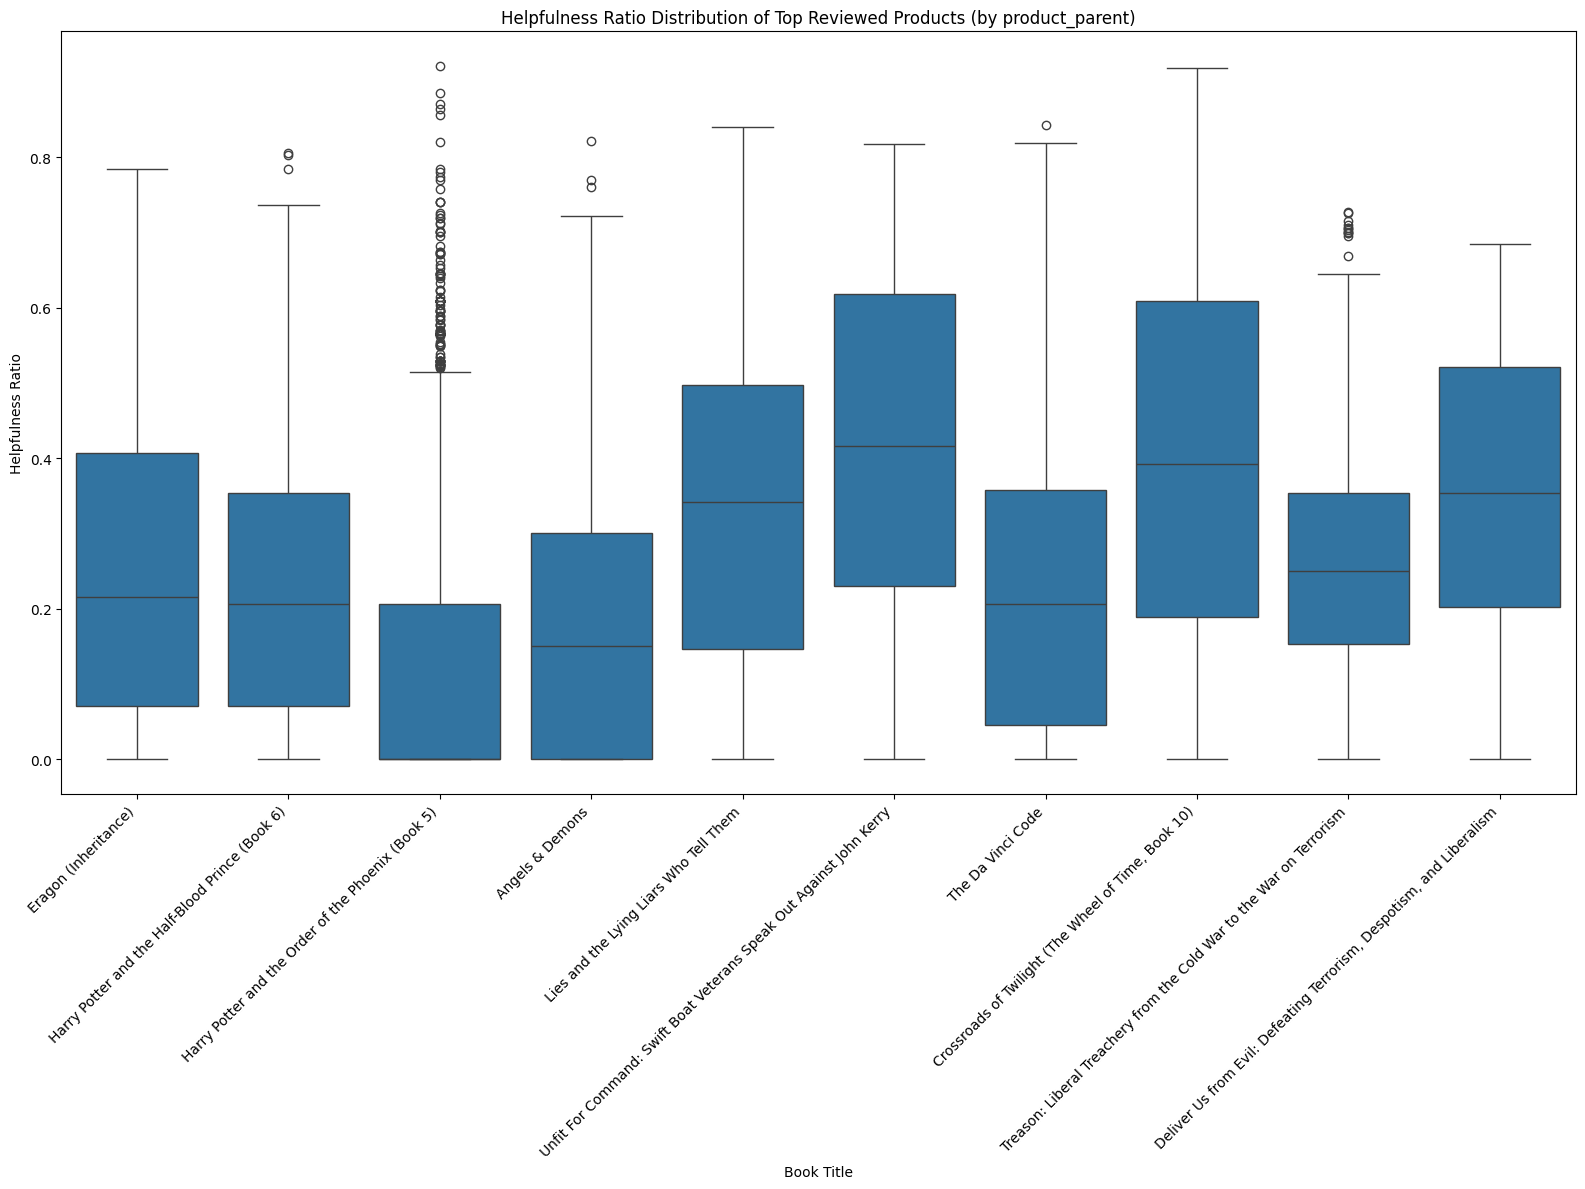

In [25]:
plt.figure(figsize=(16, 12))
sns.boxplot(data=plot_df, x='product_title_mapped', y='helpful_ratio')
plt.xticks(rotation=45, ha='right')
plt.title("Helpfulness Ratio Distribution of Top Reviewed Products (by product_parent)")
plt.xlabel("Book Title")
plt.ylabel("Helpfulness Ratio")
plt.tight_layout()
plt.show()

#### Review Helpfulness vs Review Count per Product

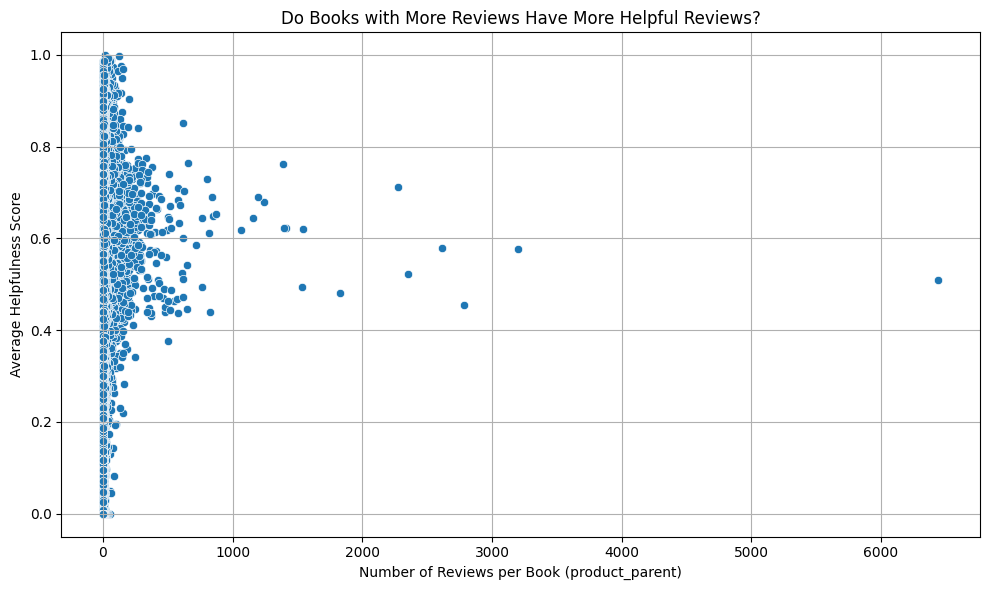

In [26]:
# Aggregate by product_parent
book_stats = df.groupby('product_parent').agg({
    'review_id': 'count',
    'helpful_votes': 'sum',
    'total_votes': 'sum'
}).rename(columns={'review_id': 'review_count'})

# Apply Wilson score
book_stats['helpful_ratio'] = book_stats.apply(
    lambda row: wilson_lower_bound(row['helpful_votes'], row['total_votes']), axis=1
)

# Optional: add readable title for hover / annotation
title_map = df.groupby('product_parent')['product_title'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
book_stats['product_title'] = book_stats.index.map(title_map)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=book_stats, x='review_count', y='helpful_ratio')

plt.xlabel("Number of Reviews per Book")
plt.ylabel("Average Helpfulness Score")
plt.title("Do Books with More Reviews Have More Helpful Reviews?")
plt.grid(True)
plt.tight_layout()
plt.show()

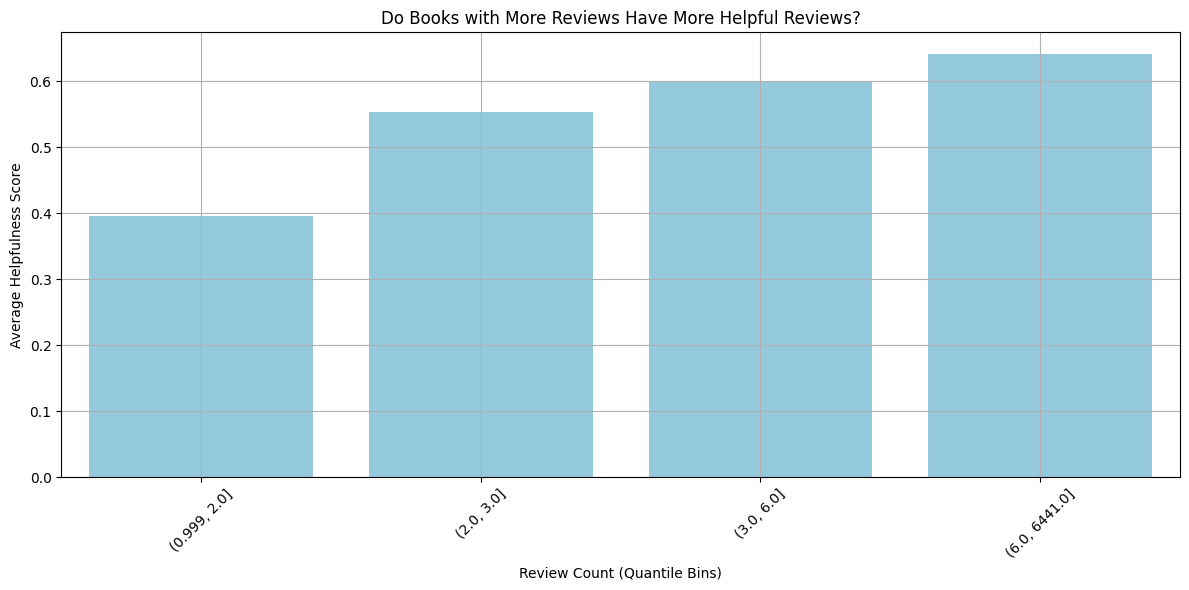

In [81]:
# Bin review_count into quantile bins (ensures balanced sample size)
book_stats['review_count_bin'] = pd.qcut(book_stats['review_count'], q=10, duplicates='drop')

# Compute average helpfulness score (wilson or helpful_ratio) per bin
binned_stats = book_stats.groupby('review_count_bin')['helpful_ratio'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=binned_stats, x='review_count_bin', y='helpful_ratio', color='skyblue')
plt.xticks(rotation=45)
plt.xlabel("Review Count (Quantile Bins)")
plt.ylabel("Average Helpfulness Score")
plt.title("Do Books with More Reviews Have More Helpful Reviews?")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Temporal Trends in Helpfulness

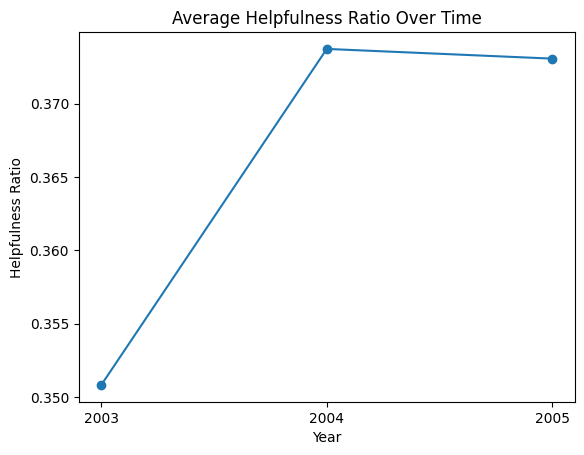

In [27]:
df['year'] = df['review_date'].dt.year.astype('Int64')
helpfulness_by_year = df.groupby('year')['helpful_ratio'].mean().reset_index()

plt.plot(helpfulness_by_year['year'], helpfulness_by_year['helpful_ratio'], marker='o')
plt.title("Average Helpfulness Ratio Over Time")
plt.xlabel("Year")
plt.ylabel("Helpfulness Ratio")
plt.xticks(helpfulness_by_year['year'])
plt.show()

In [79]:
# Direct feature creation in-place
reference_date = pd.to_datetime('2005-12-31')
df['review_age'] = (reference_date - df['review_date']).dt.days

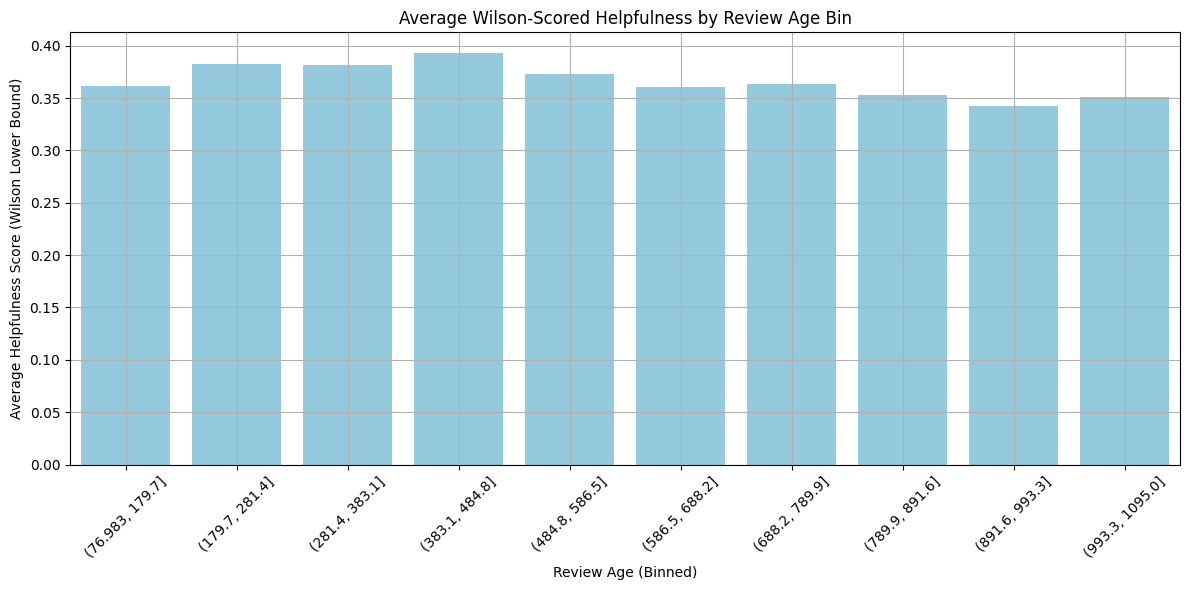

In [80]:
# Bin review age into 10 equal-width intervals
df['review_age_bin'] = pd.cut(df['review_age'], bins=10)

# Compute mean Wilson score per bin
age_helpfulness = df.groupby('review_age_bin')['helpful_ratio'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=age_helpfulness, x='review_age_bin', y='helpful_ratio', color='skyblue')
plt.xticks(rotation=45)
plt.title("Average Wilson-Scored Helpfulness by Review Age Bin")
plt.xlabel("Review Age (Binned)")
plt.ylabel("Average Helpfulness Score (Wilson Lower Bound)")
plt.tight_layout()
plt.grid(True)
plt.show()

#### Does Review Length Correlate with Helpfulness?

/tmp/ipython-input-1263413366.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('length_bin')['helpful_ratio'].mean().plot(kind='bar')


Text(0.5, 1.0, 'Avg Helpfulness by Review Length Bin')

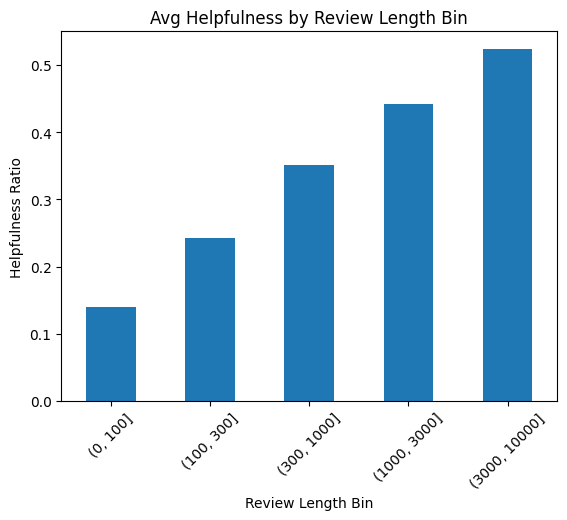

In [29]:
df['length_bin'] = pd.cut(df['review_length'], bins=[0, 100, 300, 1000, 3000, 10000])
df.groupby('length_bin')['helpful_ratio'].mean().plot(kind='bar')
plt.xlabel("Review Length Bin")
plt.xticks(rotation=45)
plt.ylabel("Helpfulness Ratio")
plt.title("Avg Helpfulness by Review Length Bin")

#### Verified vs Non-Verified Purchases

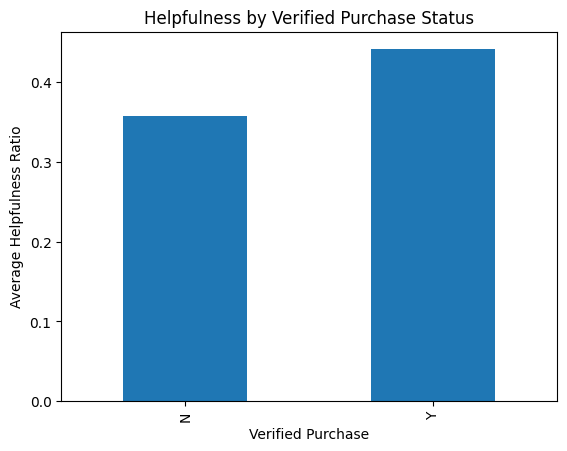

In [30]:
df.groupby('verified_purchase')['helpful_ratio'].mean().plot(kind='bar')
plt.title("Helpfulness by Verified Purchase Status")
plt.xlabel("Verified Purchase")
plt.ylabel("Average Helpfulness Ratio")
plt.show()

####  Vine Reviews (Paid/Promoted) vs Organic

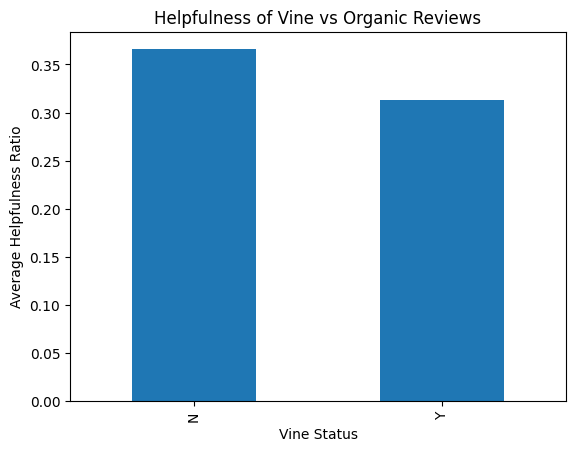

In [31]:
df['vine'].value_counts()
df.groupby('vine')['helpful_ratio'].mean().plot(kind='bar')
plt.xlabel("Vine Status")
plt.ylabel("Average Helpfulness Ratio")
plt.title("Helpfulness of Vine vs Organic Reviews")
plt.show()

#### Review Headline vs Helpfulness

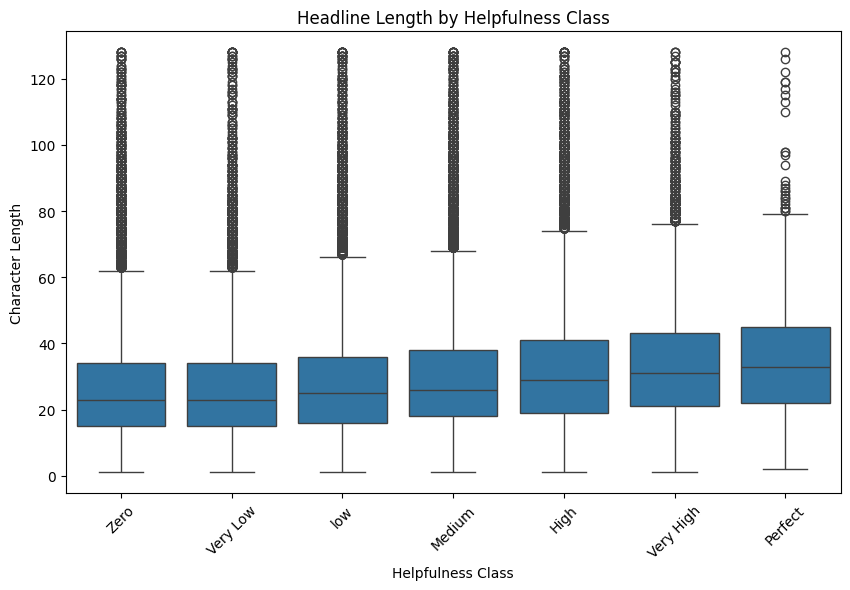

In [32]:
df['headline_length'] = df['review_headline'].astype(str).apply(len)

# # Length vs helpfulness
# sns.scatterplot(x='headline_length', y='helpful_ratio', data=df)
# plt.title("Review Headline Length vs Helpfulness")
# plt.show()

# Boxplot: Review length vs. helpful class
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['helpful_class'].notnull()], x='helpful_class', y='headline_length', order=['Zero', 'Very Low', 'low', 'Medium', 'High', 'Very High', 'Perfect'])
plt.title('Headline Length by Helpfulness Class')
plt.xlabel('Helpfulness Class')
plt.ylabel('Character Length')
plt.xticks(rotation=45)
plt.show()

/tmp/ipython-input-4034794117.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('headline_len_bin')['helpful_ratio'].mean().plot(kind='bar')


Text(0.5, 1.0, 'Avg Helpfulness by Headline Length Bin')

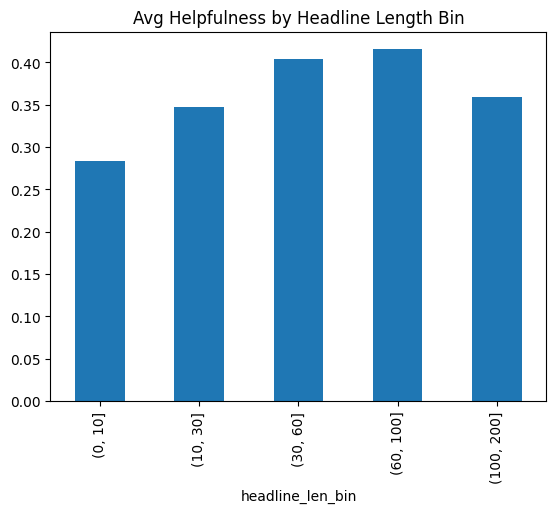

In [33]:
df['headline_len_bin'] = pd.cut(df['headline_length'], bins=[0, 10, 30, 60, 100, 200])
df.groupby('headline_len_bin')['helpful_ratio'].mean().plot(kind='bar')
plt.title("Avg Helpfulness by Headline Length Bin")

/tmp/ipython-input-3461532874.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('headline_len_bin')['helpful_ratio'].mean().plot(kind='bar')


Text(0.5, 1.0, 'Avg Helpfulness by Headline Length Bin')

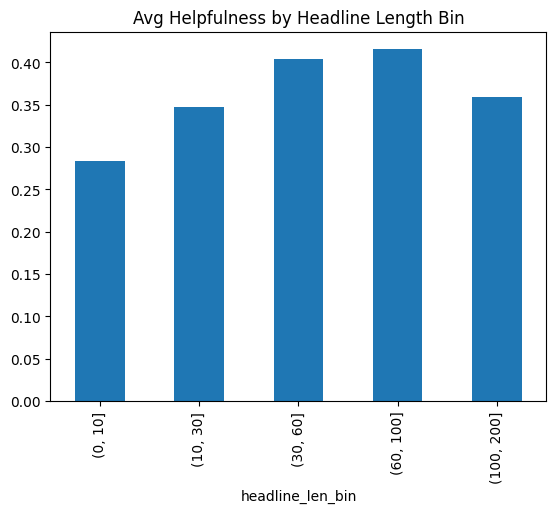

In [34]:
df['headline_word_count'] = df['review_headline'].astype(str).apply(lambda x: len(x.split()))

df['headline_word_count_bin'] = pd.cut(df['headline_word_count'], bins=[0, 3, 5, 10, 15, 20, 30, 50, 100])
df.groupby('headline_len_bin')['helpful_ratio'].mean().plot(kind='bar')
plt.title("Avg Helpfulness by Headline Length Bin")

#### Top Reviewers by Review Count

In [54]:
reviewer_stats = df.groupby('customer_id').agg({
    'review_id': 'count',
    'helpful_votes': 'sum',
    'total_votes': 'sum'
}).rename(columns={'review_id': 'review_count'})

# Apply Wilson score
reviewer_stats['avg_helpful_ratio'] = reviewer_stats.apply(
    lambda row: wilson_lower_bound(row['helpful_votes'], row['total_votes']), axis=1
)


In [60]:
top_reviewers = reviewer_stats[(reviewer_stats['review_count'] >= 100) & (reviewer_stats['avg_helpful_ratio'] >= 0.75)].sort_values(by='avg_helpful_ratio', ascending=False)
top_reviewers


,review_count,helpful_votes,total_votes,avg_helpful_ratio
customer_id,,,,
31706721,130,182.0,183.0,0.969701
52500542,215,6071.0,6255.0,0.966099
49618395,219,4107.0,4264.0,0.957098
45761633,107,517.0,531.0,0.956235
30081986,194,7854.0,8229.0,0.949708
...,...,...,...,...
18800155,218,1006.0,1290.0,0.756421
52631742,101,1227.0,1580.0,0.755387
50702879,295,5142.0,6719.0,0.755009


In [61]:
# Map frequent reviewer info back into main df
top_reviewer_ids = top_reviewers.index
df['is_top_reviewer'] = df['customer_id'].isin(top_reviewer_ids)

In [62]:
df.groupby('is_top_reviewer')['helpful_ratio'].mean()

,helpful_ratio
is_top_reviewer,
False,0.358153
True,0.446173


#### Is there a group of reviewers who write a lot but aren’t helpful?

In [63]:
bad_reviewers = reviewer_stats[(reviewer_stats['review_count'] >= 10) & (reviewer_stats['avg_helpful_ratio'] <= 0.25)].sort_values(by='avg_helpful_ratio', ascending=False)
bad_reviewers

,review_count,helpful_votes,total_votes,avg_helpful_ratio
customer_id,,,,
50777026,12,16.0,42.0,2.499973e-01
38252103,14,210.0,750.0,2.490496e-01
25884704,11,15.0,39.0,2.489137e-01
37563716,14,42.0,130.0,2.487649e-01
53007971,10,72.0,237.0,2.487606e-01
...,...,...,...,...
12790417,11,2.0,15.0,3.736126e-02
22292458,17,0.0,25.0,1.202937e-17
27436774,18,0.0,0.0,0.000000e+00


In [64]:
# Map frequent reviewer info back into main df
bad_reviewers_ids = bad_reviewers.index
df['is_bad_reviewers'] = df['customer_id'].isin(bad_reviewers_ids)

In [65]:
df.groupby('is_bad_reviewers')['helpful_ratio'].mean()

,helpful_ratio
is_bad_reviewers,
False,0.366802
True,0.125121


#### Helpfulness vs. Deviation from Product Consensus

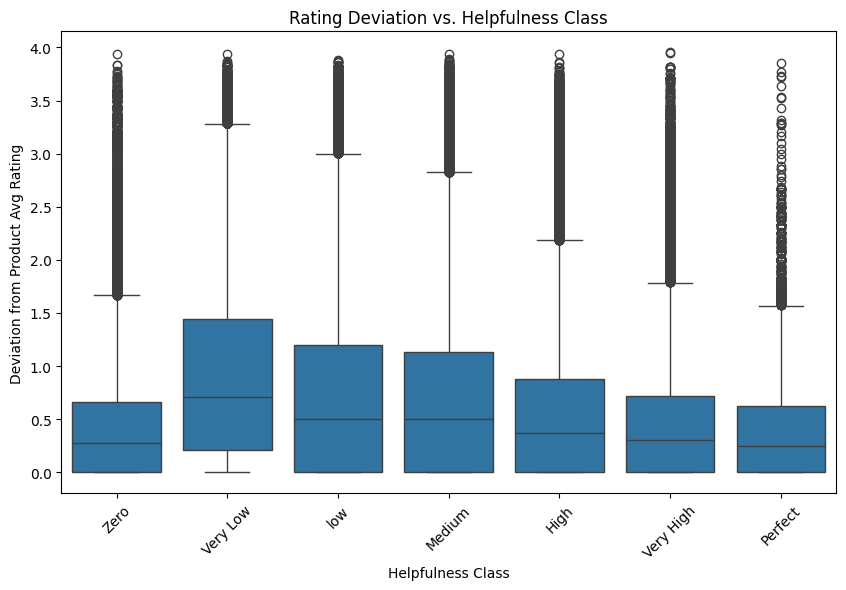

In [39]:
# Compute average rating per product
product_avg = df.groupby('product_parent')['star_rating'].mean().rename('product_avg_rating')
df = df.join(product_avg, on='product_parent')

# Compute deviation
df['rating_deviation'] = (df['star_rating'] - df['product_avg_rating']).abs()

# Plot deviation vs helpfulness
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['helpful_class'].notnull()], x='helpful_class', y='rating_deviation')
plt.title('Rating Deviation vs. Helpfulness Class')
plt.xlabel('Helpfulness Class')
plt.ylabel('Deviation from Product Avg Rating')
plt.xticks(rotation=45)
plt.show()

#### Sentiment Analysis

In [66]:
# Compute polarity from review text
# df['sentiment_polarity'] = df['review_body'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_polarity'] = df['review_body'].astype(str).swifter.apply(lambda x: TextBlob(x).sentiment.polarity)

Pandas Apply:   0%|          | 0/1286122 [00:00<?, ?it/s]

In [67]:
# Compute subjectivity from review text
# df['sentiment_subjectivity'] = df['review_body'].astype(str).apply(lambda x: TextBlob(x).sentiment.subjectivity)
df['sentiment_subjectivity'] = df['review_body'].astype(str).swifter.apply(lambda x: TextBlob(x).sentiment.subjectivity)

Pandas Apply:   0%|          | 0/1286122 [00:00<?, ?it/s]

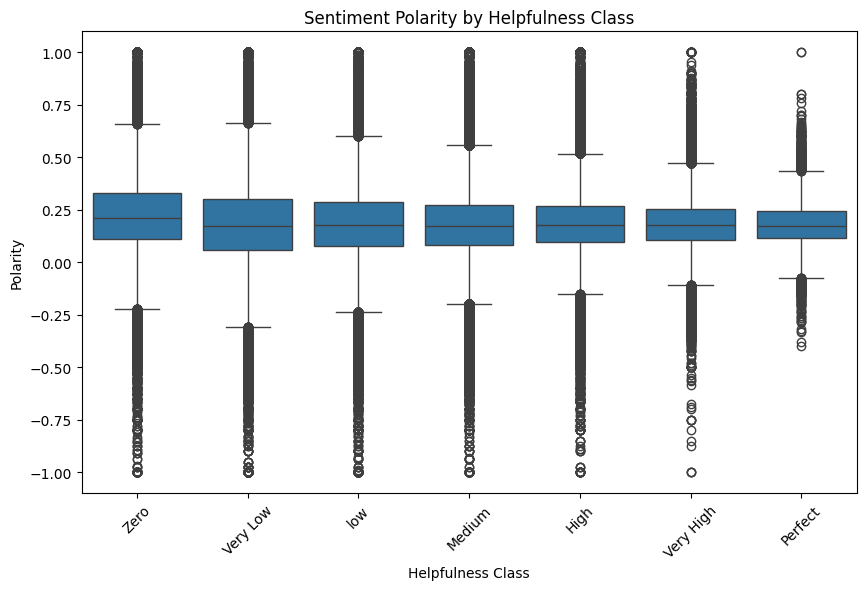

In [68]:
# Polarity vs. helpfulness class
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['helpful_class'].notnull()], x='helpful_class', y='sentiment_polarity', order=['Zero', 'Very Low', 'low', 'Medium', 'High', 'Very High', 'Perfect'])
plt.title('Sentiment Polarity by Helpfulness Class')
plt.xlabel('Helpfulness Class')
plt.ylabel('Polarity')
plt.xticks(rotation=45)
plt.show()

#### Readability

In [69]:
# df['readability'] = df['review_body'].astype(str).apply(textstat.flesch_reading_ease)
df['readability'] = df['review_body'].astype(str).swifter.apply(textstat.flesch_reading_ease)

Pandas Apply:   0%|          | 0/1286122 [00:00<?, ?it/s]

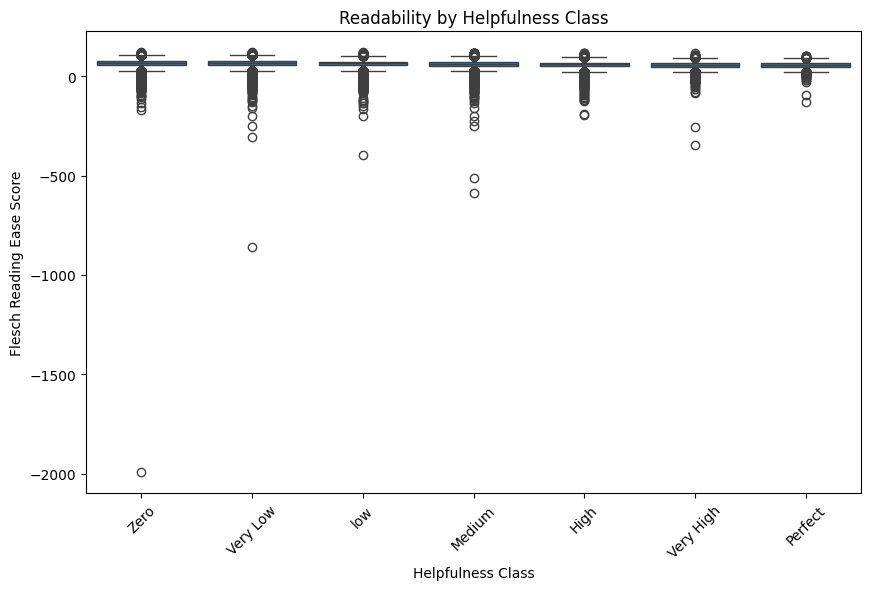

In [70]:
# Readability vs helpfulness
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['helpful_class'].notnull()], x='helpful_class', y='readability', order=['Zero', 'Very Low', 'low', 'Medium', 'High', 'Very High', 'Perfect'])
plt.title('Readability by Helpfulness Class')
plt.xlabel('Helpfulness Class')
plt.ylabel('Flesch Reading Ease Score')
plt.xticks(rotation=45)
plt.show()

#### Negation and Hedging Language

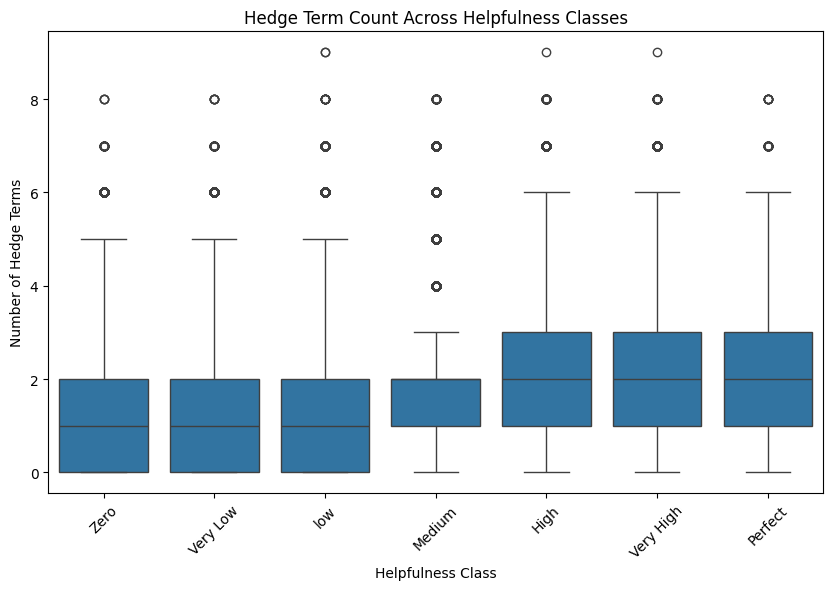

In [71]:
hedge_words = ['maybe', 'perhaps', 'somewhat', 'might', 'could', 'although', 'however', 'but', 'not']
df['hedge_count'] = df['review_body'].astype(str).apply(
    lambda x: sum(word in x.lower() for word in hedge_words)
)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['helpful_class'].notnull()], x='helpful_class', y='hedge_count',
            order=['Zero', 'Very Low', 'low', 'Medium', 'High', 'Very High', 'Perfect'])
plt.title('Hedge Term Count Across Helpfulness Classes')
plt.xlabel('Helpfulness Class')
plt.ylabel('Number of Hedge Terms')
plt.xticks(rotation=45)
plt.show()

In [72]:
# Binary flag: is the review hedged at all?
df['hedged'] = df['hedge_count'] > 0

hedged_scores = df[df['hedged']]['helpful_ratio']
non_hedged_scores = df[~df['hedged']]['helpful_ratio']

stat, p_value = ttest_ind(hedged_scores, non_hedged_scores, equal_var=False)
print(f"T-test p-value: {p_value:.5f}")

T-test p-value: 0.00000


In [74]:
print(hedged_scores.mean(), non_hedged_scores.mean())

0.38518703624144546 0.305783154944139


#### Correlate Review Features with Helpfulness

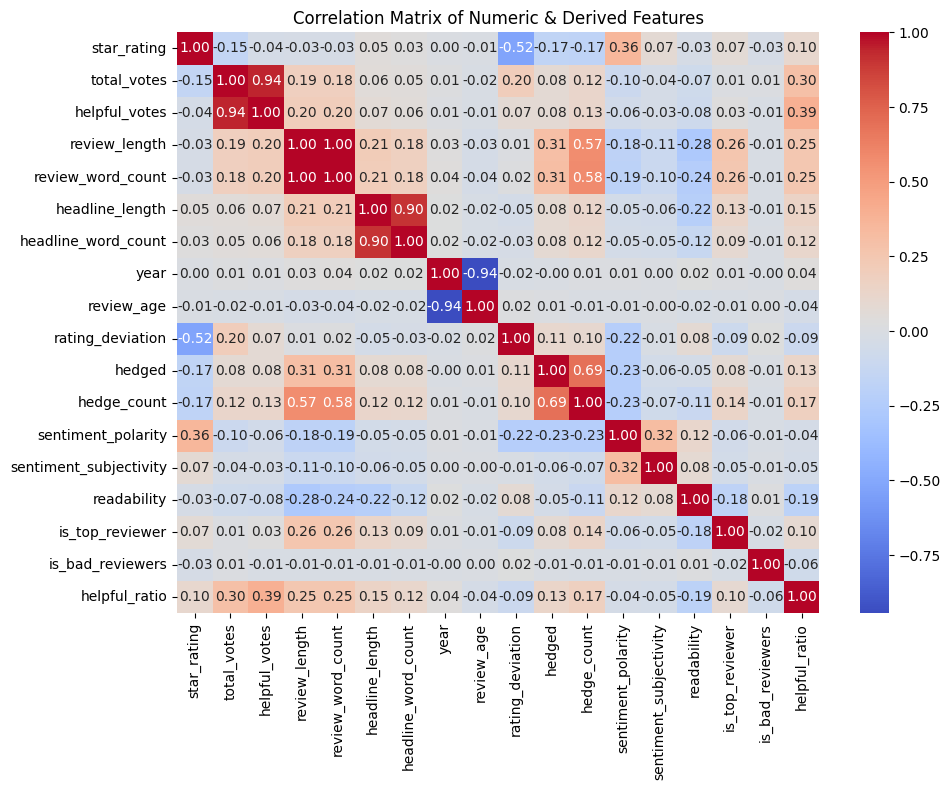

In [96]:
# Build correlation-ready DataFrame
df_corr = df.copy()

# Feature engineering
# df_corr['verified_purchase'] = df_corr['verified_purchase'].map({'Y': 1, 'N': 0})
# df_corr['vine'] = df_corr['vine'].map({'Y': 1, 'N': 0})
df_corr['engaged'] = df_corr['engaged'].astype(int)
df_corr['is_top_reviewer'] = df_corr['is_top_reviewer'].astype(int)
df_corr['is_bad_reviewers'] = df_corr['is_bad_reviewers'].astype(int)
df_corr['hedged'] = df_corr['hedged'].astype(int)

# Select numeric columns for correlation
cols_to_corr = [
    'star_rating', 'total_votes', 'helpful_votes',
    'review_length', 'review_word_count', 'headline_length',
    'headline_word_count', 'year',
    'review_age', 'rating_deviation','hedged', 'hedge_count',
    'sentiment_polarity', 'sentiment_subjectivity', 'readability',
    'is_top_reviewer', 'is_bad_reviewers', 'helpful_ratio'
]

# Calculate correlation matrix
corr_matrix = df_corr[cols_to_corr].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric & Derived Features")
plt.tight_layout()
plt.show()

In [93]:
# Features for regression
features = ['hedged', 'star_rating', 'verified_purchase', 'rating_deviation',
            'is_top_reviewer', 'helpful_votes', 'total_votes',
            'review_word_count', 'hedge_count', 'review_age',
            'headline_word_count', 'is_bad_reviewers',
            'sentiment_polarity', 'sentiment_subjectivity', 'readability']

# Drop rows with missing values
X = df[features].dropna()
y = df.loc[X.index, 'helpful_ratio']

# Add constant manually (instead of creating a column calle d 'intercept')
X = sm.add_constant(X)

# Convert all columns to numeric explicitly
X = X.apply(pd.to_numeric)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Show summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          helpful_ratio   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                 3.016e+04
Date:                Wed, 30 Jul 2025   Prob (F-statistic):               0.00
Time:                        21:47:57   Log-Likelihood:             1.1398e+05
No. Observations:             1286122   AIC:                        -2.279e+05
Df Residuals:                 1286106   BIC:                        -2.277e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

### Save the Data

In [92]:
df['vine'] = df['vine'].map({'Y': 1, 'N': 0})
df['verified_purchase'] = df['verified_purchase'].map({'Y': 1, 'N': 0})
df['engaged'] = df['engaged'].astype(int)
df['is_top_reviewer'] = df['is_top_reviewer'].astype(int)
df['is_bad_reviewers'] = df['is_bad_reviewers'].astype(int)
df['hedged'] = df['hedged'].astype(int)

In [ ]:
# Drop unnecessary columns
columns_to_drop = [
                  'marketplace', 'product_id',
                  'product_parent', 'product_title',
                  'product_category'
]

df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Save the DataFrame
output_file_path = '../data/02_preprocessed_data/processed_reviews.tsv'
# output_file_path = '/content/processed_reviews.tsv'
df.to_csv(output_file_path, sep='\t', index=False)

## Exploratory Data Analysis (EDA)

---
### Engineered Features
- `review_length`, `review_word_count`: Length metrics for review body.
- `headline_word_count`: Token count of the headline.
- `review_age`: Days between review date and 2005-12-31.
- `rating_deviation`: Distance from mean product rating.
- `sentiment_polarity`, `sentiment_subjectivity`: Extracted using TextBlob.
- `readability`: Flesch–Kincaid score using `textstat`.
- `hedged`, `hedge_count`: Flags for vague/hedging words.
- `is_top_reviewer`: Boolean for selected top reviewers.
- `is_bad_reviewers`: Flag for known spammers or low-quality accounts.

---

### Feature Relationships

#### 🔹 Length-Based Features
- Longer reviews (and headlines) → **positively associated** with helpfulness.
- Strong correlation between `review_length`, `word_count`, and `headline_word_count`.

#### 🔹 Star Ratings
- `star_rating` shows a weak positive effect.
- `rating_deviation` (i.e., disagreement with consensus) is **negatively correlated** with helpfulness.

#### 🔹 Review Authenticity
- Verified purchases are **more helpful**.
- `is_bad_reviewers` strongly **negatively correlated** with helpfulness.

#### 🔹 Sentiment & Readability
- Positive sentiment (`sentiment_polarity`) contributes positively.
- Subjective or overly readable reviews show **negative** association.

#### 🔹 Time Trend
- `review_age` has a **slight negative coefficient** — older reviews are marginally less helpful.

---

### Correlation Matrix Highlights

- Most positively correlated with `helpful_ratio`:  
  - `helpful_votes` (0.39),  
  - `review_length` / `word_count` (0.25),  
  - `sentiment_polarity` (0.19)
- Most negatively correlated:
  - `is_bad_reviewers` (−0.26),  
  - `readability` (−0.19),  
  - `rating_deviation` (−0.09)

---

### OLS Regression Summary on Helpfulness

| Feature                  | Coefficient | Direction | Significance |
|--------------------------|-------------|-----------|--------------|
| `review_word_count`      | +           | Strong positive contributor |
| `verified_purchase`      | +           | Strong and significant |
| `star_rating`            | +           | Significant |
| `sentiment_polarity`     | +           | Moderate contribution |
| `review_age`             | –           | Slight negative impact |
| `rating_deviation`       | –           | Reviews that disagree with consensus are less helpful |
| `is_bad_reviewers`       | –           | Largest negative effect |
| `total_votes`            | –           | Slight negative effect due to how helpfulness is computed |
| `readability`, `subjectivity` | –     | More readable or subjective = less helpful |

> **R² = 0.260** → The model explains ~26% of the variance in helpfulness using these features.

---

### Summary

- **Most Helpful Reviews** are: longer, objective, verified, and sentimentally positive.
- **Least Helpful Reviews** tend to be: overly simple, subjective, off-rating, or authored by low-quality users.
- Features like `review_age`, `hedged language`, and reviewer identity (top/bad) add important predictive value.
- Traditional features + NLP signals (sentiment, length, readability) together contribute meaningfully.